In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

from tools_fast import *
from clustering import cluster, cluster_net
from hc_graph import *

<IPython.core.display.Javascript object>

Open console to check js libs were loaded in page


In [3]:
fund_name = 'CARMPAT'
pd.read_csv(r"financial_data/hfrx_index_names.csv", index_col=0)

,Full Name
Name,
HFRXAR,HFRX Absolute Return Index
HFRXDS,HFRX ED: Distressed Restructuring Index
HFRXMA,HFRX ED: Merger Arbitrage Index
HFRXSS,HFRX ED: Special Situations Index
HFRXEMN,HFRX EH: Equity Market Neutral Index
HFRXEHG,HFRX EH: Fundamental Growth Index
HFRXEHV,HFRX EH: Fundamental Value Index
HFRXEMC,HFRX Emerging Markets Composite Index
HFRXEW,HFRX Equal Weighted Strategies Index


### Financial data loads and cleaning

In [4]:
# US rate
US_rate = pd.read_csv(r"financial_data/USD_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']

EUR_rate = pd.read_csv(r"financial_data/EUR_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']
EUR_USD = pd.read_csv(r"financial_data/FX_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['EUR/USD']

# HFRX
hfrx_all = pd.read_csv(r"financial_data/hfrx_daily_index_data.csv", index_col=0, parse_dates=True, dayfirst=True).ffill()
hfrx = make_ER(hfrx_all[[fund_name]].dropna(), EUR_rate)
hfrx = make_FXHedge(hfrx, EUR_USD)

# BNP

bnp = pd.read_csv(r"financial_data/bnp_data_long_term.csv", index_col=0, parse_dates=True, dayfirst=True)

risk_premia = pd.read_pickle("financial_data/risk_premia_ER_FX_USD.pkl").drop('BPCURVW4', axis=1)


In [5]:
df_info = pd.read_csv(r"financial_data/bnp_info.csv", index_col=0)
df_info

,Asset Class,Style
Ticker,,
BNPIDRXA,Commodity,Carry
BNPIF3AX,Commodity,Carry
BNPIF3XM,Commodity,Momentum
BPFXSTGU,FX,Value
BNPICCE3,Equity,Carry
BNPIVMRU,Equity,Reversal
BPCURVW4,MM,Carry
BNPIVCXA,Commodity,Volatility
BNPIAIRT,Bonds,Volatility


In [6]:
prices_all = hfrx.join(bnp,how="left").join(risk_premia,how="left").ffill()
returns_all = prices_all.pct_change().iloc[1:]
hrfx_returns = returns_all[[fund_name]]
returns_all = returns_all.drop(fund_name, axis=1)
prices_all = prices_all.drop(fund_name, axis=1).bfill()

In [7]:
prices_futur = hfrx.join(bnp,how="left")
returns_fut = prices_futur.pct_change().iloc[1:]
hrfx_returns_fut = returns_fut[[fund_name]]
returns_fut = returns_fut.drop(fund_name, axis=1)
prices_futur = prices_futur.drop(fund_name, axis=1).bfill()

In [8]:
prices_risk_premia = hfrx.join(risk_premia,how="left").ffill()
returns_risk_premia = prices_risk_premia.pct_change().iloc[1:]
hrfx_returns_rp = returns_risk_premia[[fund_name]]
returns_risk_premia = returns_risk_premia.drop(fund_name, axis=1)
prices_risk_premia = prices_risk_premia.drop(fund_name, axis=1).bfill()

## Estimation of the exposures

In [9]:
size = 126
freq = 5
freq_ml = 20

### Volatility adjustment

In [10]:
tau = 0.1
tc = 0.0005
nu = 1.0
lag_fut = 2
lag_rp = 3
lag = max(lag_fut, lag_rp)
vol_period = 60


In [11]:
%%time
df_weight_kalman_aic_voladj = selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='aic', vol_target=True, vol_period=vol_period)
df_weight_kalman_bic_voladj = selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='bic', vol_target=True, vol_period=vol_period)
df_weight_ml_kalman_bic_voladj = ml_selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq_ml,
                                                     tau=tau, criterion='bic', vol_target=True, vol_period=vol_period)
df_weight_ml_kalman_aic_voladj = ml_selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq_ml,
                                                     tau=tau, criterion='aic', vol_target=True, vol_period=vol_period)
df_weight_kalman_voladj = kalman_filter(hrfx_returns, returns_all,freq, sigma_weight=1. , sigma_return=nu,
                                        vol_target=True, vol_period=vol_period)
df_weight_ml_kalman_voladj, _ = ml_kalman_filter(hrfx_returns, returns_all, freq_ml, tau=tau, vol_target=True, vol_period=vol_period)

prices_for_track = prices_all.loc[df_weight_kalman_voladj.index[0]:]

replication_kalman_voladj = make_track(prices_for_track, df_weight_kalman_voladj, tc=tc, lag=lag)
df_res_voladj = hfrx.loc[replication_kalman_voladj.index]
df_res_voladj["Kalman VT"] = replication_kalman_voladj

replication_ml_kalman_voladj = make_track(prices_for_track, df_weight_ml_kalman_voladj, tc=tc, lag=lag)
df_res_voladj["ML Kalman VT"] = replication_ml_kalman_voladj

prices_for_track = prices_all.loc[df_weight_kalman_aic_voladj.index[0]:]

replication_kalman_aic_voladj = make_track(prices_for_track, df_weight_kalman_aic_voladj, tc=tc, lag=lag)
df_res_voladj["Kalman AIC VT"] = replication_kalman_aic_voladj

replication_ml_kalman_aic_voladj = make_track(prices_for_track, df_weight_ml_kalman_aic_voladj, tc=tc, lag=lag)
df_res_voladj["ML Kalman AIC VT"] = replication_ml_kalman_aic_voladj

replication_kalman_bic_voladj = make_track(prices_for_track, df_weight_kalman_bic_voladj, tc=tc, lag=lag)
df_res_voladj["Kalman BIC VT"] = replication_kalman_bic_voladj

replication_ml_kalman_bic_voladj = make_track(prices_for_track, df_weight_ml_kalman_bic_voladj, tc=tc, lag=lag)
df_res_voladj["ML Kalman BIC VT"] = replication_ml_kalman_bic_voladj

Wall time: 3min 20s


In [12]:
%%time
df_weight_kalman_aic_voladj_fut = selective_kalman_filter(hrfx_returns_fut, returns_fut,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='aic', vol_target=True, vol_period=vol_period)
df_weight_kalman_bic_voladj_fut = selective_kalman_filter(hrfx_returns_fut, returns_fut,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='bic', vol_target=True, vol_period=vol_period)
df_weight_ml_kalman_bic_voladj_fut = ml_selective_kalman_filter(hrfx_returns_fut, returns_fut,sample_length=size, frequency=freq_ml,
                                                     tau=tau, criterion='bic', vol_target=True, vol_period=vol_period)
df_weight_ml_kalman_aic_voladj_fut = ml_selective_kalman_filter(hrfx_returns_fut, returns_fut,sample_length=size, frequency=freq_ml,
                                                     tau=tau, criterion='aic', vol_target=True, vol_period=vol_period)
df_weight_kalman_voladj_fut = kalman_filter(hrfx_returns_fut, returns_fut,freq, sigma_weight=1. , sigma_return=nu,
                                        vol_target=True, vol_period=vol_period)
df_weight_ml_kalman_voladj_fut, _ = ml_kalman_filter(hrfx_returns_fut, returns_fut, freq_ml, tau=tau, vol_target=True, vol_period=vol_period)

prices_for_track = prices_futur.loc[df_weight_kalman_voladj_fut.index[0]:]

replication_kalman_voladj_fut = make_track(prices_for_track, df_weight_kalman_voladj_fut, tc=tc, lag=lag_fut)
df_res_voladj_fut = hfrx.loc[replication_kalman_voladj_fut.index]
df_res_voladj_fut["Kalman VT"] = replication_kalman_voladj_fut

replication_ml_kalman_voladj_fut = make_track(prices_for_track, df_weight_ml_kalman_voladj_fut, tc=tc, lag=lag_fut)
df_res_voladj_fut["ML Kalman VT"] = replication_ml_kalman_voladj_fut

prices_for_track = prices_futur.loc[df_weight_kalman_aic_voladj_fut.index[0]:]

replication_kalman_aic_voladj_fut = make_track(prices_for_track, df_weight_kalman_aic_voladj_fut, tc=tc, lag=lag_fut)
df_res_voladj_fut["Kalman AIC VT"] = replication_kalman_aic_voladj_fut

replication_ml_kalman_aic_voladj_fut = make_track(prices_for_track, df_weight_ml_kalman_aic_voladj_fut, tc=tc, lag=lag_fut)
df_res_voladj_fut["ML Kalman AIC VT"] = replication_ml_kalman_aic_voladj_fut

replication_kalman_bic_voladj_fut = make_track(prices_for_track, df_weight_kalman_bic_voladj_fut, tc=tc, lag=lag_fut)
df_res_voladj_fut["Kalman BIC VT"] = replication_kalman_bic_voladj_fut

replication_ml_kalman_bic_voladj_fut = make_track(prices_for_track, df_weight_ml_kalman_bic_voladj_fut, tc=tc, lag=lag_fut)
df_res_voladj_fut["ML Kalman BIC VT"] = replication_ml_kalman_bic_voladj_fut

Wall time: 1min 35s


In [13]:
%%time
df_weight_kalman_aic_voladj_rp = selective_kalman_filter(hrfx_returns_rp, returns_risk_premia,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='aic', vol_target=True, vol_period=vol_period)
df_weight_kalman_bic_voladj_rp = selective_kalman_filter(hrfx_returns_rp, returns_risk_premia,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='bic', vol_target=True, vol_period=vol_period)
df_weight_ml_kalman_bic_voladj_rp = ml_selective_kalman_filter(hrfx_returns_rp, returns_risk_premia,sample_length=size, frequency=freq_ml,
                                                     tau=tau, criterion='bic', vol_target=True, vol_period=vol_period)
df_weight_ml_kalman_aic_voladj_rp = ml_selective_kalman_filter(hrfx_returns_rp, returns_risk_premia,sample_length=size, frequency=freq_ml,
                                                     tau=tau, criterion='aic', vol_target=True, vol_period=vol_period)
df_weight_kalman_voladj_rp = kalman_filter(hrfx_returns_rp, returns_risk_premia,freq, sigma_weight=1. , sigma_return=nu,
                                        vol_target=True, vol_period=vol_period)
df_weight_ml_kalman_voladj_rp, _ = ml_kalman_filter(hrfx_returns_rp, returns_risk_premia, freq_ml, tau=tau, vol_target=True, vol_period=vol_period)

prices_for_track = prices_risk_premia.loc[df_weight_kalman_voladj_rp.index[0]:]

replication_kalman_voladj_rp = make_track(prices_for_track, df_weight_kalman_voladj_rp, tc=tc, lag=lag_rp)
df_res_voladj_risk_premia = hfrx.loc[replication_kalman_voladj_rp.index]
df_res_voladj_risk_premia["Kalman VT"] = replication_kalman_voladj_rp

replication_ml_kalman_voladj_rp = make_track(prices_for_track, df_weight_ml_kalman_voladj_rp, tc=tc, lag=lag_rp)
df_res_voladj_risk_premia["ML Kalman VT"] = replication_ml_kalman_voladj_rp

prices_for_track = prices_risk_premia.loc[df_weight_kalman_aic_voladj_rp.index[0]:]

replication_kalman_aic_voladj_rp = make_track(prices_for_track, df_weight_kalman_aic_voladj_rp, tc=tc, lag=lag_rp)
df_res_voladj_risk_premia["Kalman AIC VT"] = replication_kalman_aic_voladj_rp

replication_ml_kalman_aic_voladj_rp = make_track(prices_for_track, df_weight_ml_kalman_aic_voladj_rp, tc=tc, lag=lag_rp)
df_res_voladj_risk_premia["ML Kalman AIC VT"] = replication_ml_kalman_aic_voladj_rp

replication_kalman_bic_voladj_rp = make_track(prices_for_track, df_weight_kalman_bic_voladj_rp, tc=tc, lag=lag_rp)
df_res_voladj_risk_premia["Kalman BIC VT"] = replication_kalman_bic_voladj_rp

replication_ml_kalman_bic_voladj_rp = make_track(prices_for_track, df_weight_ml_kalman_bic_voladj_rp, tc=tc, lag=lag_rp)
df_res_voladj_risk_premia["ML Kalman BIC VT"] = replication_ml_kalman_bic_voladj_rp

Wall time: 33.7 s


### All Factors

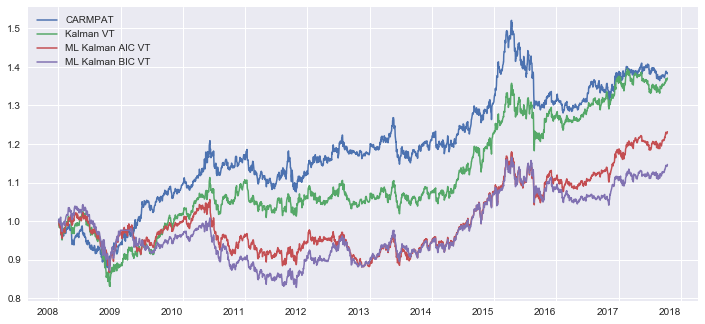

In [14]:
df_res_voladj = df_res_voladj.loc['2008':'2017-10-13']
df_res_voladj = (df_res_voladj / df_res_voladj.iloc[0])
df_res_voladj[[fund_name, 'Kalman VT', 'ML Kalman AIC VT', 'ML Kalman BIC VT']].plot(figsize=(12,6), rot=0, linewidth=1.5)
df_res_volperfadj = df_res_voladj[[fund_name]].copy()
temp = df_res_voladj.drop(fund_name, axis=1)
df_res_volperfadj[temp.columns]= make_ER(temp, 2 + 0 * US_rate)

In [15]:
df_stat_vol = replication_stats(df_res_voladj, fund_name=fund_name)
df_stat_vol

,Correlation,Kendall tau,Tracking error,R-squared,Sharpe ratio,Annual Return,Maximum Drawdown
CARMPAT,1.000000,1.000000,0.000000,1.000000,0.450325,0.033707,-0.151403
Kalman VT,0.796889,0.601603,0.052804,0.576072,0.420174,0.032308,-0.188609
ML Kalman VT,0.748767,0.562002,0.058889,0.472734,0.439884,0.034193,-0.199641
Kalman AIC VT,0.736203,0.535406,0.060665,0.440462,0.217813,0.015043,-0.181717
ML Kalman AIC VT,0.725219,0.510320,0.060999,0.434285,0.292548,0.021085,-0.155442
Kalman BIC VT,0.695994,0.493836,0.064907,0.359466,0.075574,0.002802,-0.263032
ML Kalman BIC VT,0.681235,0.468520,0.065324,0.351201,0.205798,0.013636,-0.198301


### Classic Factors

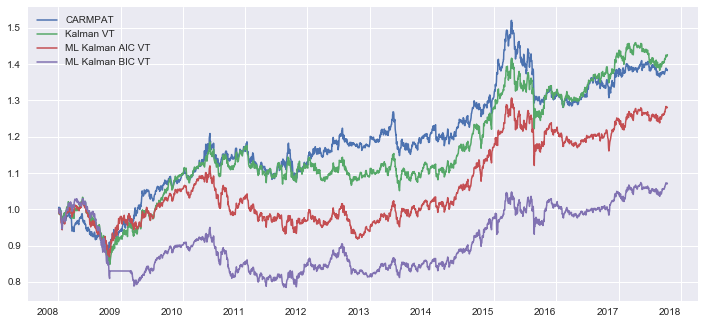

In [16]:
df_res_voladj_fut = df_res_voladj_fut.loc['2008':'2017-10-13']
df_res_voladj_fut = (df_res_voladj_fut / df_res_voladj_fut.iloc[0])
df_res_voladj_fut[[fund_name, 'Kalman VT', 'ML Kalman AIC VT', 'ML Kalman BIC VT']].plot(figsize=(12,6), rot=0, linewidth=1.5)
df_res_volperfadj_fut = df_res_voladj_fut[[fund_name]].copy()
temp = df_res_voladj_fut.drop(fund_name, axis=1)
df_res_volperfadj_fut[temp.columns]= make_ER(temp, 2 + 0 * US_rate)

In [17]:
df_stat_vol_fut = replication_stats(df_res_voladj_fut, fund_name=fund_name)
df_stat_vol_fut

,Correlation,Kendall tau,Tracking error,R-squared,Sharpe ratio,Annual Return,Maximum Drawdown
CARMPAT,1.000000,1.000000,0.000000,1.000000,0.450325,0.033707,-0.151403
Kalman VT,0.804547,0.600570,0.052133,0.586775,0.464085,0.036475,-0.177442
ML Kalman VT,0.743486,0.548349,0.059685,0.458382,0.357492,0.027133,-0.197679
Kalman AIC VT,0.761699,0.549705,0.057539,0.496628,0.219480,0.015147,-0.183176
ML Kalman AIC VT,0.759616,0.545345,0.057876,0.490720,0.337268,0.025425,-0.169629
Kalman BIC VT,0.693851,0.496842,0.065775,0.342227,-0.016713,-0.005176,-0.285025
ML Kalman BIC VT,0.674237,0.494909,0.066888,0.319770,0.123984,0.006907,-0.234938


### Risk Premia

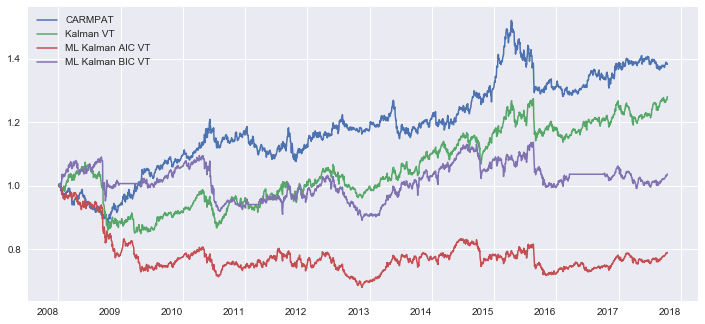

In [18]:
df_res_voladj_risk_premia = df_res_voladj_risk_premia.loc['2008':'2017-10-13']
df_res_voladj_risk_premia = (df_res_voladj_risk_premia / df_res_voladj_risk_premia.iloc[0])
df_res_voladj_risk_premia[[fund_name, 'Kalman VT', 'ML Kalman AIC VT', 'ML Kalman BIC VT']].plot(figsize=(12,6), rot=0, linewidth=1.5)
df_res_volperfadj_risk_premia = df_res_voladj_risk_premia[[fund_name]].copy()
temp = df_res_voladj_risk_premia.drop(fund_name, axis=1)
df_res_volperfadj_risk_premia[temp.columns]= make_ER(temp, 2 + 0 * US_rate)

In [19]:
df_stat_vol_risk_premia = replication_stats(df_res_voladj_risk_premia, fund_name=fund_name)
df_stat_vol_risk_premia

,Correlation,Kendall tau,Tracking error,R-squared,Sharpe ratio,Annual Return,Maximum Drawdown
CARMPAT,1.000000,1.000000,0.000000,1.000000,0.450325,0.033707,-0.151403
Kalman VT,0.502580,0.345352,0.082699,-0.039833,0.334275,0.024929,-0.200067
ML Kalman VT,0.405459,0.252128,0.092898,-0.312127,-0.516392,-0.048586,-0.426265
Kalman AIC VT,0.450115,0.296922,0.085702,-0.116714,0.168754,0.010497,-0.173728
ML Kalman AIC VT,0.431331,0.277229,0.088312,-0.185767,-0.245730,-0.024011,-0.316664
Kalman BIC VT,0.465674,0.276081,0.082826,-0.043009,0.396885,0.028582,-0.170223
ML Kalman BIC VT,0.453456,0.272291,0.085465,-0.110555,0.082756,0.003396,-0.180718


## Volatility Contributions

In [20]:
df_weight_kalman_voladj_ = df_weight_kalman_voladj.loc['2008':'2017-10-13']
df_vol_contrib_kalman_voladj = (prices_all.reindex(df_weight_kalman_voladj_.index).pct_change()*df_weight_kalman_voladj_).std()
df_vol_contrib_kalman_voladj = df_vol_contrib_kalman_voladj/df_vol_contrib_kalman_voladj.sum()

df_weight_ml_kalman_bic_voladj_ = df_weight_ml_kalman_bic_voladj.loc['2008':'2017-10-13']
df_vol_contrib_ml_kalman_bic_voladj = (prices_all.reindex(df_weight_ml_kalman_bic_voladj_.index).pct_change()*df_weight_ml_kalman_bic_voladj_).std()
df_vol_contrib_ml_kalman_bic_voladj = df_vol_contrib_ml_kalman_bic_voladj/df_vol_contrib_ml_kalman_bic_voladj.sum()

df_weight_ml_kalman_aic_voladj_ = df_weight_ml_kalman_aic_voladj.loc['2008':'2017-10-13']
df_vol_contrib_ml_kalman_aic_voladj = (prices_all.reindex(df_weight_ml_kalman_aic_voladj_.index).pct_change()*df_weight_ml_kalman_aic_voladj_).std()
df_vol_contrib_ml_kalman_aic_voladj = df_vol_contrib_ml_kalman_aic_voladj/df_vol_contrib_ml_kalman_aic_voladj.sum()

In [21]:
vol_contrib = pd.DataFrame()
# vol_contrib['Kalman'] = df_vol_contrib_kalman_voladj
vol_contrib["ML Kalman AIC VT"] = df_vol_contrib_ml_kalman_aic_voladj
vol_contrib["ML Kalman BIC VT"] = df_vol_contrib_ml_kalman_bic_voladj
vol_contrib = vol_contrib.join(df_info).reset_index()

In [22]:
vol_contrib_asset_class = vol_contrib.drop(["Style"],axis=1).groupby(["Asset Class","index"]).sum()
vol_contrib_style = vol_contrib.drop(["Asset Class"],axis=1).groupby(["Style","index"]).sum()

In [23]:
repli = "ML Kalman BIC VT"
g = hc_piechart(vol_contrib_asset_class[[repli]], title="Vol contribution by Asset Class in " + repli)
g.plot()

In [24]:
g = hc_piechart(vol_contrib_style[[repli]], title="Vol contribution by Style in " + repli)
g.plot()

## Performance contributions

In [25]:
perf_contrib_kalman_voladj = (1 + prices_all.reindex(df_weight_kalman_voladj_.index).pct_change()*df_weight_kalman_voladj_).prod() - 1
perf_contrib_ml_kalman_bic_voladj = (1 + prices_all.reindex(df_weight_ml_kalman_bic_voladj_.index).pct_change()*df_weight_ml_kalman_bic_voladj_).prod() - 1
perf_contrib_ml_kalman_aic_voladj = (1 + prices_all.reindex(df_weight_ml_kalman_aic_voladj_.index).pct_change()*df_weight_ml_kalman_aic_voladj_).prod() - 1

In [26]:
perf_contrib = pd.DataFrame()
# perf_contrib["Kalman"] = perf_contrib_kalman_voladj
perf_contrib["ML Kalman AIC VT"] = perf_contrib_ml_kalman_aic_voladj
perf_contrib["ML Kalman BIC VT"] = perf_contrib_ml_kalman_bic_voladj
perf_contrib = perf_contrib.join(df_info).reset_index()

In [27]:
perf_contrib_asset_class = perf_contrib.drop(["Style"],axis=1).groupby(["Asset Class","index"]).sum()
perf_contrib_style = perf_contrib.drop(["Asset Class"],axis=1).groupby(["Style","index"]).sum()

In [28]:
g = hc_spiderweb(perf_contrib_asset_class, title="Performance contribution by Asset Class")
g.plot()

In [29]:
g = hc_spiderweb(perf_contrib_style, title="Performance contribution by Style")
g.plot()

## plt charts

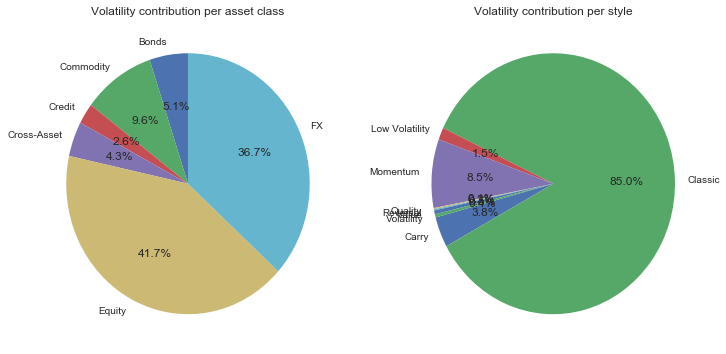

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,6))
vol_contrib_asset_class.groupby(level=0).sum().plot(kind='pie', y=repli, legend=False, autopct='%1.1f%%', ax=ax1,
                                              title='Volatility contribution per asset class', startangle=90)
ax1.set_ylabel('')
vol_contrib_style.groupby(level=0).sum().plot(kind='pie', y=repli, legend=False, autopct='%1.1f%%', ax=ax2,
                                              title='Volatility contribution per style', startangle=195)
_ = ax2.set_ylabel('')

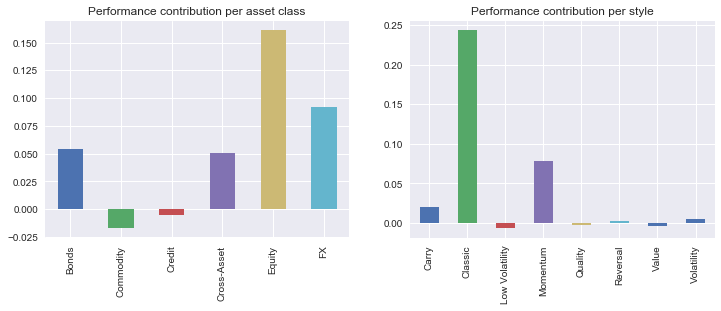

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,4))
perf_contrib_asset_class[repli].groupby(level=0).sum().plot(kind='bar', ax=ax1,
                                                     title='Performance contribution per asset class')
ax1.set_xlabel('')
perf_contrib_style[repli].groupby(level=0).sum().plot(kind='bar', ax=ax2,
                                                     title='Performance contribution per style')
_ = ax2.set_xlabel('')